
=== Tableau comparatif (sportif vs non-sportif) ===



,reps,amplitude_totale,stabilite_glob,vitesse_moy_glob,jerk_mean,amplitude_mean_rep,amplitude_std_rep,corr_amp_stabilite_local,p_amp_stabilite_local,corr_amp_mean_speed_local,p_amp_mean_speed_local,corr_amp_symetrie_local,p_amp_symetrie_local,rep_amplitudes_series,amplitude_CV_rep
label,,,,,,,,,,,,,,,
Sportif,144,1.130031,0.123386,0.524016,7.612809,0.234870,0.223316,0.991679,2.545999e-128,0.717005,5.149215e-24,0.054250,0.518409,"[0.3972406804583184, 0.027550675922333845, 0.0...",0.950805
Non-Sportif,102,1.884558,0.192815,1.135961,17.289271,0.448264,0.372505,0.994684,1.503178e-100,0.839349,3.180693e-28,0.018651,0.852400,"[0.2446490870225113, 0.16745590869203109, 0.26...",0.830993


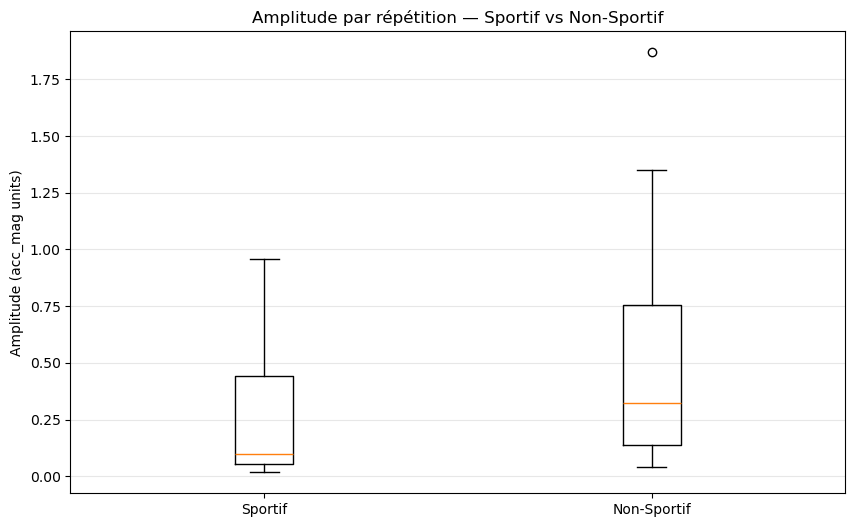

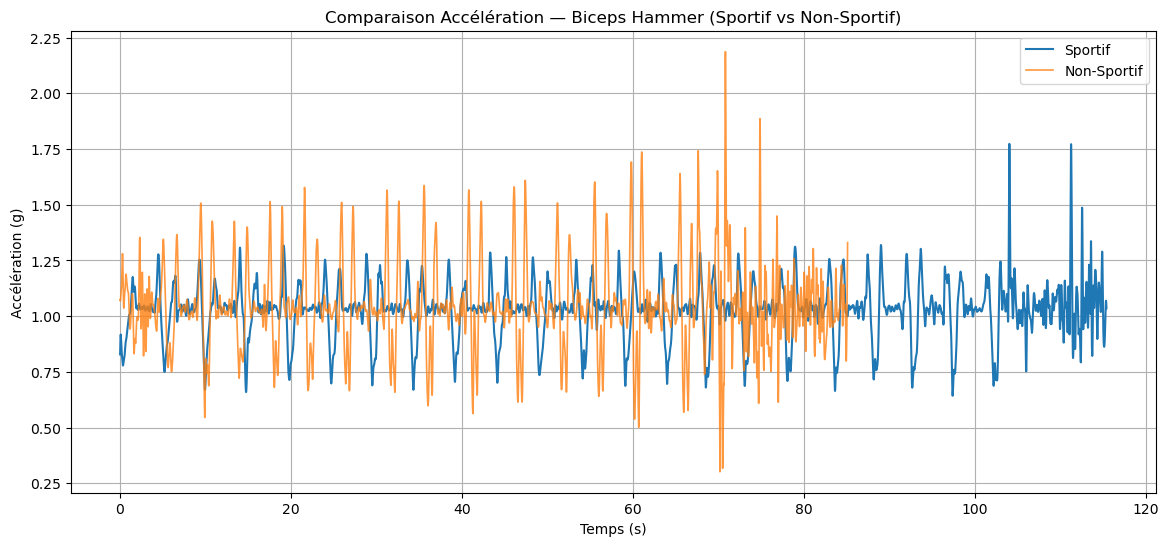


===== Résumé Sportif vs Non-Sportif =====
Sportif — reps: 144, Non-Sportif — reps: 102
Amplitude moyenne par rép (Sportif): 0.235 | (Non-Sportif): 0.448
Écart-type amplitude par rép (Sportif): 0.223 | (Non-Sportif): 0.373
Stabilité globale (std acc_mag) — Sportif: 0.123 | Non-Sportif: 0.193
Vitesse moyenne globale — Sportif: 0.524 | Non-Sportif: 1.136
Jerk moyen — Sportif: 7.6128 | Non-Sportif: 17.2893
corr_amp_stabilite_local — Sportif: 0.992 | Non-Sportif: 0.995
corr_amp_mean_speed_local — Sportif: 0.717 | Non-Sportif: 0.839
corr_amp_symetrie_local — Sportif: 0.054 | Non-Sportif: 0.019
✔ Le sportif réalise des répétitions de plus faible amplitude moyenne que le non-sportif.
✔ Le sportif est globalement plus stable (std acc_mag plus faible).
✔ Le sportif a un jerk moyen plus faible → mouvement plus propre.



In [4]:
import pandas as pd               # Importation de la librairie pandas, utilisée pour manipuler des dataframes
import numpy as np                # Importation de NumPy, utile pour les calculs scientifiques
import matplotlib.pyplot as plt   # Importation de Matplotlib pour générer des graphiques
from scipy.signal import butter, filtfilt, find_peaks   # Importation de fonctions pour filtrage et détection de pics
from scipy.stats import pearsonr  # Importation de la corrélation de Pearson


def butter_lowpass_filter(data, cutoff=5, fs=100, order=4):
    nyq = 0.5 * fs                      # Calcul de la fréquence de Nyquist
    normal_cutoff = cutoff / nyq        # Normalisation de la fréquence de coupure
    b, a = butter(order, normal_cutoff, btype='low', analog=False)  # Filtre passe-bas Butterworth
    return filtfilt(b, a, data)         # Application d’un filtrage sans déphasage


def compute_rep_windows(peaks, n_samples):
    starts = []     # Liste pour stocker les indices de début de chaque répétition
    ends = []       # Liste pour stocker les indices de fin de chaque répétition

    for i, p in enumerate(peaks):
        if i == 0:
            start = 0                   # Pour le premier pic, la répétition commence au tout début
        else:
            start = int((peaks[i-1] + p) / 2)  # Sinon, milieu entre pic précédent et pic actuel

        if i == len(peaks)-1:
            end = n_samples - 1         # Pour le dernier pic, fin au dernier échantillon
        else:
            end = int((p + peaks[i+1]) / 2)    # Sinon, milieu entre pic actuel et suivant

        starts.append(start)
        ends.append(end)

    return list(zip(starts, ends))      # Renvoie une liste de paires (début, fin)


def process_file(file_path, label, peak_distance=40, peak_prominence=None, fs_guess=100):
    df = pd.read_csv(file_path)                     # Chargement du fichier CSV
    df.columns = ["Temps", "ax", "ay", "az"]        # Renommage des colonnes

    df["ax_f"] = butter_lowpass_filter(df["ax"])    # Filtrage de ax
    df["ay_f"] = butter_lowpass_filter(df["ay"])    # Filtrage de ay
    df["az_f"] = butter_lowpass_filter(df["az"])    # Filtrage de az

    df["acc_mag"] = np.sqrt(df["ax_f"]**2 + df["ay_f"]**2 + df["az_f"]**2)  # Module d’accélération

    df["speed"] = np.gradient(df["acc_mag"], df["Temps"])                  # Vitesse = dérivée de l’accélération
    df["jerk"] = np.gradient(df["speed"], df["Temps"])                     # Jerk = dérivée de la vitesse

    seuil = np.mean(df["acc_mag"])                                         # Seuil basé sur la moyenne du signal

    peaks, props = find_peaks(                                             # Détection des pics
        df["acc_mag"],
        height=seuil,
        distance=peak_distance,
        prominence=peak_prominence
    )

    rep_windows = compute_rep_windows(peaks, len(df))                      # Découpage des répétitions

    amplitude_tot = df["acc_mag"].max() - df["acc_mag"].min()              # Amplitude totale du mouvement
    stabilite_glob = df["acc_mag"].std()                                   # Variabilité globale du signal
    vitesse_moy_glob = np.abs(df["speed"]).mean()                          # Vitesse moyenne absolue
    jerk_mean = np.abs(df["jerk"]).mean()                                  # Jerk moyen

    rep_rows = []   # Liste contenant les métriques de chaque répétition

    for i, (start, end) in enumerate(rep_windows):
        seg = df.iloc[start:end+1]                                         # Segment correspondant à une répétition

        if len(seg) < 3:                                                   # Si trop petit, ignorer
            continue

        amp = seg["acc_mag"].max() - seg["acc_mag"].min()                  # Amplitude locale
        dur = seg["Temps"].iloc[-1] - seg["Temps"].iloc[0]                 # Durée de la répétition
        stab_local = seg["acc_mag"].std()                                  # Stabilité locale
        mean_speed_local = np.abs(seg["speed"]).mean()                     # Vitesse moyenne locale

        ascent = seg["speed"][seg["speed"] > 0].mean() if (seg["speed"] > 0).any() else 0.0
        descent = abs(seg["speed"][seg["speed"] < 0].mean()) if (seg["speed"] < 0).any() else 0.0

        sym_local = 1 - (abs(ascent - descent) / max(ascent, descent)) if max(ascent, descent) != 0 else 1.0

        rep_rows.append({
            "rep_id": i,
            "start_idx": start,
            "end_idx": end,
            "amplitude": amp,
            "duration": dur,
            "stabilite_local": stab_local,
            "mean_speed_local": mean_speed_local,
            "symetrie_local": sym_local
        })

    rep_df = pd.DataFrame(rep_rows)   # Création du tableau final contenant toutes les répétitions

    amplitude_mean_rep = rep_df["amplitude"].mean() if not rep_df.empty else np.nan
    amplitude_std_rep = rep_df["amplitude"].std() if not rep_df.empty else np.nan

    corrs = {}  # Dictionnaire pour stocker les corrélations

    if len(rep_df) >= 3:
        for col in ["stabilite_local", "mean_speed_local", "symetrie_local"]:
            try:
                r, p = pearsonr(rep_df["amplitude"].fillna(0), rep_df[col].fillna(0))  # Corrélation amplitude ↔ autre paramètre
            except Exception:
                r, p = np.nan, np.nan
            corrs[f"corr_amp_{col}"] = r
            corrs[f"p_amp_{col}"] = p
    else:
        corrs = {f"corr_amp_{c}": np.nan for c in ["stabilite_local", "mean_speed_local", "symetrie_local"]}
        corrs.update({f"p_amp_{c}": np.nan for c in ["stabilite_local", "mean_speed_local", "symetrie_local"]})

    metrics = {
        "label": label,                                # Sportif ou Non-Sportif
        "reps": len(rep_df),                           # Nombre de répétitions détectées
        "amplitude_totale": amplitude_tot,             # Amplitude totale du signal
        "stabilite_glob": stabilite_glob,              # Stabilité globale
        "vitesse_moy_glob": vitesse_moy_glob,          # Vitesse moyenne
        "jerk_mean": jerk_mean,                        # Jerk moyen
        "amplitude_mean_rep": amplitude_mean_rep,      # Amplitude moyenne par répétition
        "amplitude_std_rep": amplitude_std_rep,        # Variabilité de l’amplitude
    }

    metrics.update(corrs)                              # Ajout des corrélations aux métriques

    metrics["rep_amplitudes_series"] = rep_df["amplitude"].values if not rep_df.empty else np.array([])

    return df, rep_df, metrics, peaks                  # Renvoi de toutes les données utiles


# --- Chargement des fichiers CSV ---
ffile_s = r"D:\Bureau\PROJET DENIS MOTTET\CWA-DATA nico bicep hamer.csv"          # Fichier du sportif
file_ns = r"D:\Bureau\PROJET DENIS MOTTET\CWA-DATA ACHRAF bicep HAMER.csv"       # Fichier du non-sportif

df_s, rep_df_s, metrics_s, peaks_s = process_file(ffile_s, "Sportif")            # Traitement sportif
df_ns, rep_df_ns, metrics_ns, peaks_ns = process_file(file_ns, "Non-Sportif")    # Traitement non-sportif

# Comparaison globale
compare_df = pd.DataFrame([metrics_s, metrics_ns]).set_index("label")            # Table comparative
compare_df["amplitude_CV_rep"] = compare_df["amplitude_std_rep"] / compare_df["amplitude_mean_rep"]  # Coefficient de variation

print("\n=== Tableau comparatif (sportif vs non-sportif) ===\n")
display(compare_df)                                                              # Affichage du tableau


# --- BOX PLOT DES AMPLITUDES ---
plt.figure(figsize=(10,6))
data_for_box = [metrics_s["rep_amplitudes_series"], metrics_ns["rep_amplitudes_series"]]  # Données à tracer
plt.boxplot(data_for_box, labels=["Sportif", "Non-Sportif"], showfliers=True)             # Boxplot
plt.title("Amplitude par répétition — Sportif vs Non-Sportif")
plt.ylabel("Amplitude (acc_mag units)")
plt.grid(axis="y", alpha=0.3)
plt.show()


# --- PLOT DE L’ACCÉLÉRATION COMPARÉE ---
plt.figure(figsize=(14,6))

plt.plot(df_s["Temps"], df_s["acc_mag"], label="Sportif", linewidth=1.5)         # Trace sportif
plt.plot(df_ns["Temps"], df_ns["acc_mag"], label="Non-Sportif", linewidth=1.2, alpha=0.8) # Trace non-sportif

plt.title("Comparaison Accélération — Biceps Hammer (Sportif vs Non-Sportif)")
plt.xlabel("Temps (s)")
plt.ylabel("Accélération (g)")
plt.legend()
plt.grid(True)
plt.show()


# --- Fonction de résumé automatique ---
def auto_summary(metrics_s, metrics_ns):
    s = []
    s.append("===== Résumé Sportif vs Non-Sportif =====")
    s.append(f"Sportif — reps: {int(metrics_s['reps'])}, Non-Sportif — reps: {int(metrics_ns['reps'])}")
    s.append(f"Amplitude moyenne par rép (Sportif): {metrics_s['amplitude_mean_rep']:.3f} | (Non-Sportif): {metrics_ns['amplitude_mean_rep']:.3f}")
    s.append(f"Écart-type amplitude par rép (Sportif): {metrics_s['amplitude_std_rep']:.3f} | (Non-Sportif): {metrics_ns['amplitude_std_rep']:.3f}")
    s.append(f"Stabilité globale (std acc_mag) — Sportif: {metrics_s['stabilite_glob']:.3f} | Non-Sportif: {metrics_ns['stabilite_glob']:.3f}")
    s.append(f"Vitesse moyenne globale — Sportif: {metrics_s['vitesse_moy_glob']:.3f} | Non-Sportif: {metrics_ns['vitesse_moy_glob']:.3f}")
    s.append(f"Jerk moyen — Sportif: {metrics_s['jerk_mean']:.4f} | Non-Sportif: {metrics_ns['jerk_mean']:.4f}")

    for key in ["corr_amp_stabilite_local", "corr_amp_mean_speed_local", "corr_amp_symetrie_local"]:
        s.append(f"{key} — Sportif: {metrics_s.get(key):.3f} | Non-Sportif: {metrics_ns.get(key):.3f}")

    # Analyse qualitative automatique
    if metrics_s["amplitude_mean_rep"] < metrics_ns["amplitude_mean_rep"]:
        s.append("✔ Le sportif réalise des répétitions de plus faible amplitude moyenne que le non-sportif.")
    else:
        s.append("✔ Le sportif réalise des répétitions de plus grande amplitude.")

    if metrics_s["stabilite_glob"] < metrics_ns["stabilite_glob"]:
        s.append("✔ Le sportif est globalement plus stable (std acc_mag plus faible).")
    else:
        s.append("✔ Le non-sportif est globalement plus stable.")

    if metrics_s["jerk_mean"] < metrics_ns["jerk_mean"]:
        s.append("✔ Le sportif a un jerk moyen plus faible → mouvement plus propre.")
    else:
        s.append("✔ Le non-sportif a un jerk moyen plus propre (surprenant).")

    return "\n".join(s)


# Affichage du résumé final
print("\n" + auto_summary(metrics_s, metrics_ns) + "\n")
